###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

An simple MLP training using graphs

In [1]:
import numpy as np
from graphs.core import Param
from graphs.core import DataHolder
from graphs.core import Graph
from graphs.nodes import linear_node
from graphs.nodes import bias_node
from graphs.nodes import sigmoid_node
from graphs.nodes import relu_node
from graphs.nodes import leaky_relu_node
from graphs.nodes import softmax_mce_node
from graphs.optimizers import AdamOptimizer
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime
import pathlib
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Plotting function
def plot_boundary(h_node, X_node,
                  X_train,y_train,X_test,y_test,
                  poly=None,scaler=None,xlim=(0,1),ylim=(0,1)):
    # Creates an auxiliary graph
    graph = Graph()
    graph.build(h_node)
    # Generates mesh
    pts = 100
    x1 = np.linspace(xlim[0], xlim[1], pts)  # x1
    x2 = np.linspace(ylim[0], ylim[1], pts)  # x2
    x1, x2 = np.meshgrid(x1, x2)
    mesh = np.vstack((x1.flatten(), x2.flatten())).T
    if poly is not None:
        mesh = poly.transform(mesh)
    if scaler is not None:
        mesh = scaler.transform(mesh)
    # Training set
    if scaler is not None:
        temp = scaler.inverse_transform(X_train)
    else:
        temp = X_train
    plt.scatter(temp[:,0],temp[:,1],cmap='viridis', c=y_train.flatten(), s=50, edgecolor='k')
    # Boundary
    graph.feed({X_node: mesh})
    graph.forward()
    h = h_node.value
    indexes = set(range(h.shape[1]))
    for i in range(0, len(indexes) - 1):
        g = h[:,i] - h[:,list(indexes - {i})].max(axis=1)
        plt.contour(x1, x2, g.reshape((pts,pts)), levels = [0], colors='black')
    # Decision regions
    y_pred = h.argmax(axis=1).reshape((pts,pts))
    plt.contourf(x1, x2, y_pred, alpha = 0.10,cmap='viridis')
    # Test set
    graph.feed({X_node: X_test})
    graph.forward()
    y_pred = h_node.value.argmax(axis=1)
    correct = (y_pred == y_test.flatten())
    if scaler is not None:
        temp = scaler.inverse_transform(X_test)
    else:
        temp = X_test
    plt.scatter(temp[correct,0],temp[correct,1], marker='.', c='black', s=60)
    plt.scatter(temp[~correct,0],temp[~correct,1], marker='x', c='black', s=60)

In [3]:
# Loads dataset
predictors, responses = make_circles(noise=0.1, factor=0.5, random_state=1, n_samples=300)

In [4]:
# Splits into training/test sets
X_train, X_test, y_train, y_test = train_test_split(predictors,responses,stratify=responses)

### Using custom graph implementation
Here we use our custom toy implemenations defining a computation graph that represents a MLP and train it for 1000 epochs.

In [5]:
# Builds models inputs and params
X_node = DataHolder()
y_node = DataHolder()

In [6]:
# Build hidden layers and all proper connections
def build_custom_mlp(features, categories, input_node, hidden_config):
    input_shape = (features,)
    for config in hidden_config:
        # init weights and bias
        w_node = Param((input_shape[0], config[0]))
        b_node = Param((1, config[0]))
        # builds hidden layer
        r_node = linear_node(input_node,w_node)
        z_node = bias_node(r_node, b_node)
        if config[1] == 'sigmoid':
            h_node = sigmoid_node(z_node)
        elif config[1] == 'relu':
            h_node = relu_node(z_node)
        elif config[1] == 'leaky':
            h_node = leaky_relu_node(z_node)
        else:
            h_node = z_node
        # stores last node to connect to next layer
        input_node = h_node
        input_shape = (config[0],)

    w_node = Param((input_shape[0], categories))
    b_node = Param((1, categories))
    r_node = linear_node(input_node,w_node)
    z_node = bias_node(r_node,b_node)
    J_node = softmax_mce_node(z_node,y_node)
    return J_node, J_node.h_node

In [7]:
# Hidden layers config
hidden_config = [(100, 'leaky'), (30, 'leaky'), (15, 'leaky')]

In [8]:
# Builds connections
d = predictors.shape[1]
n = len(np.unique(responses))
J_node, h_node = build_custom_mlp(d, n, X_node, hidden_config)

In [9]:
# Graph helper object
graph = Graph()
graph.build(J_node).initialize()

In [10]:
# Computing the accuracy of the model with random weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  156.61814829079077
Accuracy (Training):  0.48
Accuracy (Test):  0.51


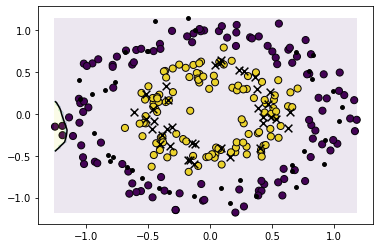

In [11]:
# Plots boundary
plot_boundary(h_node, X_node,
              X_train,y_train,X_test,y_test,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

In [12]:
# Training
start = time.perf_counter()
graph.feed({X_node: X_train, y_node: y_train})
niter,history = graph.minimize(optimizer=AdamOptimizer(alpha=1e-2))
end = time.perf_counter()
print('In {:} iteration ({:} secs) cost went from {:} to {:}'.format(niter,end-start,history[0],history[-1]))

In 1000 iteration (1.2770390000000003 secs) cost went from 156.61814829079077 to 0.0007277645869400223


In [13]:
# Computing the accuracy of the model with trained weights and bias
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Cost: ', J_node.value)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
graph.feed({X_node: X_test, y_node: y_test})
graph.forward()
y_pred = (J_node.h_node.value).argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Cost:  0.000726364779488618
Accuracy (Training):  1.00
Accuracy (Test):  1.00


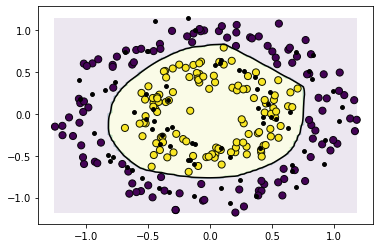

In [14]:
# Plots boundary
plot_boundary(J_node.h_node,X_node,
              X_train,y_train,X_test,y_test,
              xlim=(predictors[:,0].min(), predictors[:,0].max()),
              ylim=(predictors[:,1].min(), predictors[:,1].max()))

#### Some interesting visualizations!

In [15]:
# Running graph with training data
graph.feed({X_node: X_train, y_node: y_train})
graph.forward()
for operation in graph.post_order:
    if isinstance(operation,leaky_relu_node):
        X_hidden = operation.value
        break

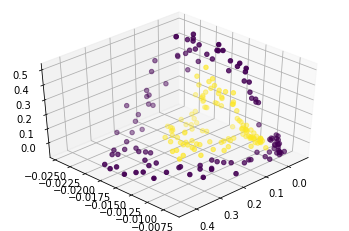

In [16]:
# Plot observations in the training set using the features learned
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hidden[:,0],X_hidden[:,1],X_hidden[:,2],c=y_train,s=20)
ax.view_init(elev=40, azim=45)

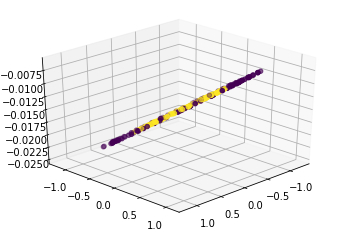

In [17]:
# Plot original features (only two) with respect to any of the new learned ones at the hidden layer
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0],X_train[:,1],X_hidden[:,1],c=y_train,s=20)
ax.view_init(azim=45)

### Building tensorflow graph
Here we use tensorflow to create the same computational graph and perform training for 1000 epochs as well.

In [18]:
class MLP:
    def __init__(self, features, categories, hidden_config):
        self.layers = []
        # Defines hidden layers
        for config in hidden_config:
            if config[1] == 'sigmoid':
                self.layers.append((
                    config[1],
                    tf.keras.layers.Dense(config[0], kernel_initializer=tf.keras.initializers.glorot_uniform())
                ))
            elif config[1] == 'relu' or config[1] == 'leaky':
                self.layers.append((
                    config[1],
                    tf.keras.layers.Dense(config[0], kernel_initializer=tf.keras.initializers.he_uniform())
                ))
            else:
                self.layers.append((
                    'linear',
                    tf.keras.layers.Dense(config[0], kernel_initializer=tf.keras.initializers.glorot_normal())
                ))
        # Defines last layer
        self.layers.append((
            'softmax', tf.keras.layers.Dense(categories, activation='softmax')
        ))
        # Defines loss
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
        
    def __call__(self, inputs):
        x = inputs
        for activation, layer in self.layers:
            x = layer(x)
            if activation == 'sigmoid':
                x = tf.keras.activations.sigmoid(x)
            elif activation == 'relu':
                x = tf.keras.activations.relu(x)
            elif activation == 'leaky':
                x = tf.keras.activations.relu(x, alpha=0.1)
        return x
    
    def train(self, inputs, outputs, optimizer=None):
        # Creates optimizer if needed
        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam()
        # Creates predictors and responses
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y_true = tf.convert_to_tensor(outputs, dtype=tf.float32)
        # Training loop
        variables = [variable for _, layer in self.layers for variable in layer.trainable_variables]
        for epoch in range(1000):
            with tf.GradientTape() as tape:
                y_pred = self.__call__(inputs)
                loss = self.loss(y_true, y_pred)            
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

In [19]:
# Creates tensorflow model
model = MLP(features=d, categories=n, hidden_config=hidden_config)

In [20]:
# Workaround to export graph
inputs = tf.random.uniform((1, d))
@tf.function
def export_graph():   
    model(inputs)

In [21]:
# Set up logging.
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = pathlib.Path('logs/%s' % stamp)
writer = tf.summary.create_file_writer(str(logdir))
tf.summary.trace_on(graph=True, profiler=False)
# Call only one tf.function when tracing.
export_graph()
# Stores to file
with writer.as_default():
    tf.summary.trace_export(name="build_tensorflow_mlp_trace", step=0, profiler_outdir=str(logdir))

In [22]:
model.train(X_train, y_train)

In [23]:
# Computing the accuracy of the model with trained weights and bias
inputs = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_pred = model(inputs)
y_pred = y_pred.numpy().argmax(axis=1)
print('Accuracy (Training): ', '%.2f' % accuracy_score(y_train, y_pred))
inputs = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_pred = model(inputs)
y_pred = y_pred.numpy().argmax(axis=1)
print('Accuracy (Test): ', '%.2f' % accuracy_score(y_test, y_pred))

Accuracy (Training):  1.00
Accuracy (Test):  1.00
